In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error

from gbnet.models.forecasting import Forecast


urls = [
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv",
]

datasets = pd.DataFrame([
    {
        'name': url.split('/')[-1],
        'data': pd.read_csv(url),
        'url': url,
        'ycol': (
            'y' if not (url.split('/')[-1] == 'example_pedestrians_multivariate.csv')
            else 'location_4'
        )
    }
    for url in urls
])

n_trials = 500
results = []
for _ in range(n_trials):

    seed = 1110011 + _
    dataset = datasets.sample(1, random_state=seed)

    df = dataset['data'].iloc[0].copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = df[dataset['ycol']].copy()

    np.random.seed(seed)
    train_q = np.random.random()
    test_q = np.random.random()
    train_cutoff = df['ds'].quantile(train_q)
    test_cutoff = df[df['ds'] > train_cutoff]['ds'].quantile(test_q)

    train = df[(df['ds'] <= train_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
    test = df[(df['ds'] > train_cutoff) & (df['ds'] <= test_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
        
        
    m = Forecast()
    m.fit(train, train['y'])
    
    test['gbnet_pred'] = m.predict(test)['yhat']
    
    pm = Prophet()
    pm.fit(train)
    test['prophet_pred'] = pm.predict(test)['yhat']

    sel = test['y'].notnull()
    results.append({
        'name': dataset['name'].iloc[0],
        'train_q': train_q,
        'test_q': test_q,
        'rmse_gbnet': root_mean_squared_error(test[sel]['y'], test[sel]['gbnet_pred']),
        'rmse_prophet': root_mean_squared_error(test[sel]['y'], test[sel]['prophet_pred'])
    })
    print(results[-1])
        


In [2]:
rrr = pd.DataFrame(results)

rrr['gbnet_wins'] = rrr['rmse_gbnet'] < rrr['rmse_prophet']

rrr['gbnet_wins'].mean()

0.794

In [3]:
rrr['gbnet_over_prophet'] = rrr['rmse_gbnet'] / rrr['rmse_prophet']
rrr['prophet_over_gbnet'] = rrr['rmse_prophet'] / rrr['rmse_gbnet']

In [4]:
rrr.groupby('name')['gbnet_wins'].mean()

name
example_air_passengers.csv              0.780000
example_pedestrians_covid.csv           0.767857
example_pedestrians_multivariate.csv    0.703704
example_retail_sales.csv                0.853333
example_wp_log_R.csv                    0.915254
example_wp_log_R_outliers1.csv          0.816667
example_wp_log_R_outliers2.csv          0.775510
example_wp_log_peyton_manning.csv       0.622222
example_yosemite_temps.csv              0.846154
Name: gbnet_wins, dtype: float64

Text(0.5, 1.0, 'P(Losing RMSE / Winning RMSE > x)')

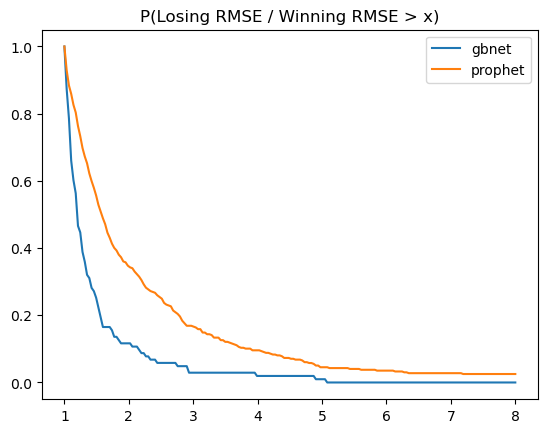

In [5]:
import numpy as np
icdf_grid = np.linspace(0.999, 8, 200)
gbnet_icdf = []
prophet_icdf = []
for c in icdf_grid:
    gbnet_icdf.append((rrr[~rrr['gbnet_wins']]['gbnet_over_prophet'] > c).mean())
    prophet_icdf.append((rrr[rrr['gbnet_wins']]['prophet_over_gbnet'] > c).mean())

plt.plot(icdf_grid, gbnet_icdf, label='gbnet')
plt.plot(icdf_grid, prophet_icdf, label='prophet')
plt.legend()
plt.title('P(Losing RMSE / Winning RMSE > x)')


In [6]:
from scipy.stats import ks_2samp, ttest_ind
print(ks_2samp(
    rrr[~rrr['gbnet_wins']]['gbnet_over_prophet'],
    rrr[rrr['gbnet_wins']]['prophet_over_gbnet'],
))

print(ttest_ind(
    rrr[~rrr['gbnet_wins']]['gbnet_over_prophet'],
    rrr[rrr['gbnet_wins']]['prophet_over_gbnet'],
))

KstestResult(statistic=0.33704238096402633, pvalue=9.116576530316228e-09, statistic_location=1.3469971795514595, statistic_sign=1)
TtestResult(statistic=-3.786202618803983, pvalue=0.0001716262977805401, df=498.0)


In [7]:
# Look at specific example and smoothness

dataset = datasets.iloc[2]
print(dataset['name'])

df = dataset['data'].copy()
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df[dataset['ycol']].copy()

train_cutoff = df['ds'].quantile(0.4)
test_cutoff = df[df['ds'] > train_cutoff]['ds'].quantile(0.2)

train = df[(df['ds'] <= train_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
test = df[(df['ds'] > train_cutoff) & (df['ds'] <= test_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()

m = Forecast()
m.fit(train, train['y'])
test['gbnet_pred'] = m.predict(test)['yhat']

pm = Prophet()
pm.fit(train)
prophet_breakdown = pm.predict(test)
test['prophet_pred'] = prophet_breakdown['yhat']

19:47:28 - cmdstanpy - INFO - Chain [1] start processing
19:47:28 - cmdstanpy - INFO - Chain [1] done processing


example_pedestrians_multivariate.csv


In [8]:
sel = test['y'].notnull()
{
    'name': dataset['name'],
    'rmse_gbnet': root_mean_squared_error(test[sel]['y'], test[sel]['gbnet_pred']),
    'rmse_prophet': root_mean_squared_error(test[sel]['y'], test[sel]['prophet_pred'])
}

{'name': 'example_pedestrians_multivariate.csv',
 'rmse_gbnet': 432.68842685091283,
 'rmse_prophet': 766.2802401759562}

Text(0.5, 1.0, 'example_pedestrians_multivariate.csv')

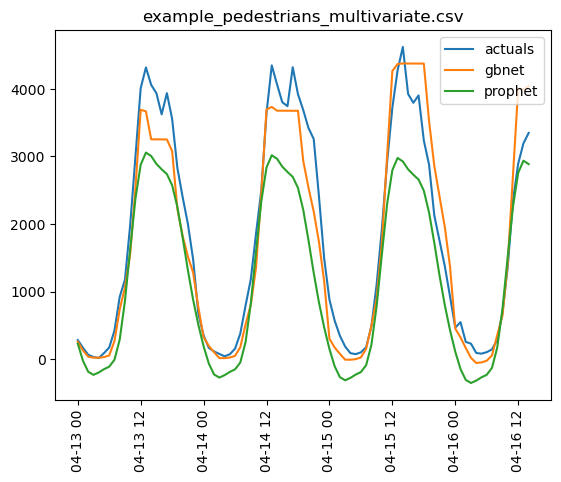

In [9]:
plt.plot(test['ds'], test['y'], label='actuals')
plt.plot(test['ds'], test['gbnet_pred'], label='gbnet')
plt.plot(test['ds'], test['prophet_pred'], label='prophet')

_ = plt.xticks(rotation=90)
plt.legend()
plt.title(f"{dataset['name']}")